In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
# import torch

In [5]:
import data.constructKG as constructKG

In [6]:
data_path = '../Data'
files = ['EN-NEG20.csv', 'EN-NEG21.csv', 'EN-NEG22M.csv', 'NEG-NEG22F.csv']
# Merge all data into one dataframe
df = pd.DataFrame()
for file in files:
    temp_df = pd.read_csv(f'{data_path}/{file}')
    df = pd.concat([df, temp_df], axis=0)

In [7]:
df.shape

(2796480, 45)

In [8]:
# Variables we care about
vars = ['student.age', 'student.gender_desc', 'student_originSchool.isITESM',
        'student.lastTerm_gpa_program', 'student.term_gpa_program', 
        'student.semester_desc', 'student.id','subject.longName', 
        'subject.type_desc','student.isConditioned','group.isVirtual', 'group.isEnglishLanguage',
        'group.isLIFE', 'student_grades.final_numeric_afterAdjustment','group.duration_weeks',
        'competence.desc', 'subcompetence.level_assigned', 'subcompetence.level_required',
]

gpa_df = df[vars]
# If last term gpa is missing, fill it with term gpa
gpa_df['student.lastTerm_gpa_program'] = gpa_df['student.lastTerm_gpa_program'].fillna(gpa_df['student.term_gpa_program'])
# Drop rows with missing values
gpa_df = gpa_df.dropna()

C:\Users\tafoy\AppData\Local\Temp\ipykernel_27984\2697802633.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gpa_df['student.lastTerm_gpa_program'] = gpa_df['student.lastTerm_gpa_program'].fillna(gpa_df['student.term_gpa_program'])


In [9]:
graph_constructor = constructKG.GraphConstructor()

In [10]:
# embeddings = graph_constructor.get_embeddings_from_df(gpa_df, node2vec_epochs=10)

In [11]:
embedding_path = './KG_gc/student_embeddings.pkl'
embeddings = pickle.load(open(embedding_path, 'rb'))

In [ ]:
import numpy as np

# Define the desired column order
desired_columns = [
    'student.id',
    'achieved_First Semester', 'not_achieved_First Semester',
    'achieved_Second Semester', 'not_achieved_Second Semester',
    'achieved_Third Semester', 'not_achieved_Third Semester',
    'achieved_Fourth Semester', 'not_achieved_Fourth Semester',
    'achieved_Fifth Semester', 'not_achieved_Fifth Semester',
    'achieved_Sixth Semester', 'not_achieved_Sixth Semester',
    'achieved_Seventh Semester', 'not_achieved_Seventh Semester',
    'achieved_Eighth Semester', 'not_achieved_Eighth Semester',
    'achieved_No information', 'not_achieved_No information'
]

# Initialize the DataFrame with the desired column order
student_df = pd.DataFrame(columns=desired_columns)

# Populate the 'student.id' column with unique student IDs
student_df['student.id'] = gpa_df['student.id'].unique()  # Ensure unique student IDs

# Iterate over semesters to populate achievement columns
for semester in gpa_df['student.semester_desc'].unique():
    achieved_col = f'achieved_{semester}'
    not_achieved_col = f'not_achieved_{semester}'
    
    # Initialize columns with NaN
    student_df[achieved_col] = np.nan
    student_df[not_achieved_col] = np.nan
    
    # Filter data for the current semester
    semester_data = gpa_df[gpa_df['student.semester_desc'] == semester]
    for student_id in student_df['student.id']:
        student_rows = semester_data[semester_data['student.id'] == student_id]
        
        if not student_rows.empty:
            # Count achieved and not achieved subcompetencies
            achieved_count = (student_rows['subcompetence.level_assigned'] == 'Observed').sum()
            not_achieved_count = (student_rows['subcompetence.level_assigned'] == 'Not observed').sum()
            
            # Update the corresponding columns
            student_df.loc[student_df['student.id'] == student_id, achieved_col] = achieved_count
            student_df.loc[student_df['student.id'] == student_id, not_achieved_col] = not_achieved_count

# Save the final DataFrame
student_df.to_csv('student_subcompetence_analysis_with_nan.csv', index=False)
print("Final DataFrame saved as 'student_subcompetence_analysis_with_nan.csv'.")


Final DataFrame saved as 'student_subcompetence_analysis_with_nan.csv'.


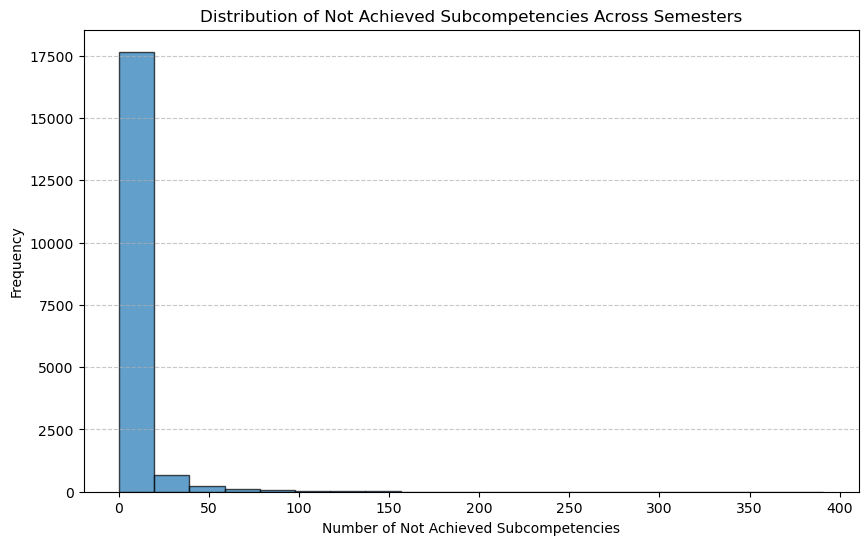

In [13]:
# Load the CSV file for analysis
analysis_df = pd.read_csv('student_subcompetence_analysis_with_nan.csv')

# Select only the columns for "not achieved" subcompetencies
not_achieved_columns = [col for col in analysis_df.columns if col.startswith("not_achieved_")]

# Combine all "not achieved" values into a single series for histogram analysis
not_achieved_data = analysis_df[not_achieved_columns].stack().dropna()

# Plot a histogram of the combined data
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(not_achieved_data, bins=20, edgecolor='black', alpha=0.7)
plt.title("Distribution of Not Achieved Subcompetencies Across Semesters")
plt.xlabel("Number of Not Achieved Subcompetencies")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


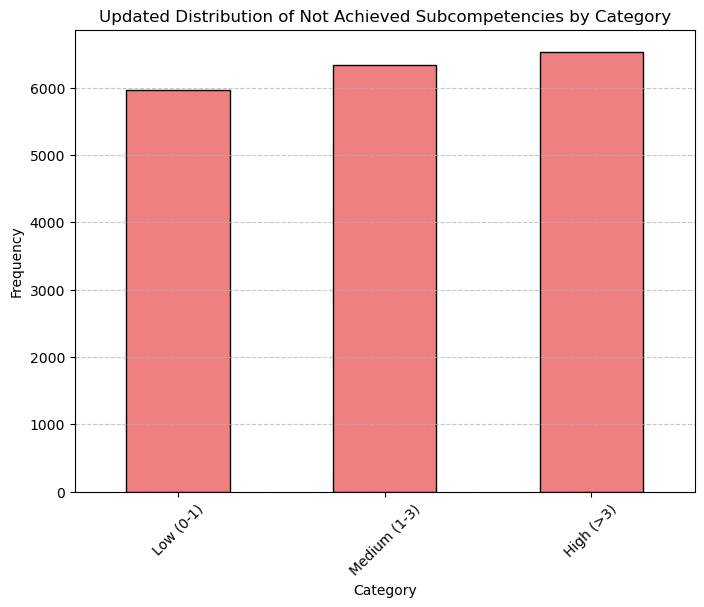

In [14]:
# New bins to reduce imbalance
bins = [0, 1, 3, np.inf]
labels = ['Low (0-1)', 'Medium (1-3)', 'High (>3)']

# Apply updated binning
not_achieved_data_binned = pd.cut(not_achieved_data, bins=bins, labels=labels, right=False)

# Count the number of students in each category
category_counts = not_achieved_data_binned.value_counts().sort_index()

# Plot the updated bar chart
plt.figure(figsize=(8, 6))
category_counts.plot(kind='bar', color='lightcoral', edgecolor='black')
plt.title("Updated Distribution of Not Achieved Subcompetencies by Category")
plt.xlabel("Category")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.show()


In [38]:
import numpy as np

semester = 'Third Semester'
sem_embeddings = embeddings[semester]

# Create lists for embeddings and labels
embedding_list = []
labels = []

for node_label, embedding in sem_embeddings.items():
    embedding_list.append(embedding)
    labels.append(node_label)

embedding_array = np.array(embedding_list)
student_ids = [label.replace('student_', '') for label in labels]

In [16]:
import umap.umap_ as umap

reducer = umap.UMAP(n_components=2, random_state=42)
embedding_2d = reducer.fit_transform(embedding_array)

c:\Users\tafoy\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

student_categories_df = pd.read_csv('student_subcompetence_analysis_with_nan.csv')

print(student_categories_df.columns)

Index(['student.id', 'achieved_First Semester', 'not_achieved_First Semester',
       'achieved_Second Semester', 'not_achieved_Second Semester',
       'achieved_Third Semester', 'not_achieved_Third Semester',
       'achieved_Fourth Semester', 'not_achieved_Fourth Semester',
       'achieved_Fifth Semester', 'not_achieved_Fifth Semester',
       'achieved_Sixth Semester', 'not_achieved_Sixth Semester',
       'achieved_Seventh Semester', 'not_achieved_Seventh Semester',
       'achieved_Eighth Semester', 'not_achieved_Eighth Semester',
       'achieved_No information', 'not_achieved_No information'],
      dtype='object')


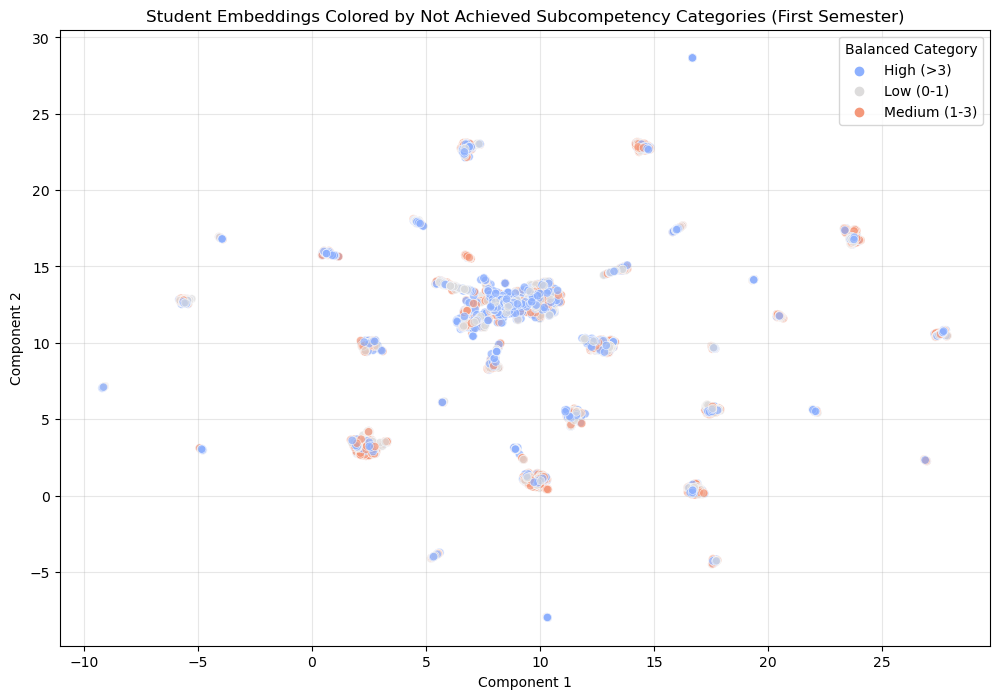

In [18]:
# Select the "not achieved" column for the specified semester
not_achieved_column = f'not_achieved_{semester}'

# Ensure the column exists
if not_achieved_column not in student_categories_df.columns:
    raise ValueError(f"The column '{not_achieved_column}' does not exist in the data.")

# Map the "not achieved" counts to balanced categories
bins = [0, 1, 3, np.inf]
labels = ['Low (0-1)', 'Medium (1-3)', 'High (>3)']
student_categories_df['balanced_category'] = pd.cut(
    student_categories_df[not_achieved_column],
    bins=bins,
    labels=labels,
    right=False
)

# Create a dictionary mapping student IDs to balanced categories
balanced_category_dict = dict(zip(student_categories_df['student.id'].astype(str), student_categories_df['balanced_category']))

# Map the categories to the embeddings
not_achieved_categories = [balanced_category_dict.get(student_id, 'Unknown') for student_id in student_ids]

# Plot the embeddings
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=embedding_2d[:, 0],
    y=embedding_2d[:, 1],
    hue=not_achieved_categories,
    palette='coolwarm',
    alpha=0.7
)

# Customize the plot
plt.title(f'Student Embeddings Colored by Not Achieved Subcompetency Categories ({semester})')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(title='Balanced Category', loc='upper right')
plt.grid(alpha=0.3)
plt.show()

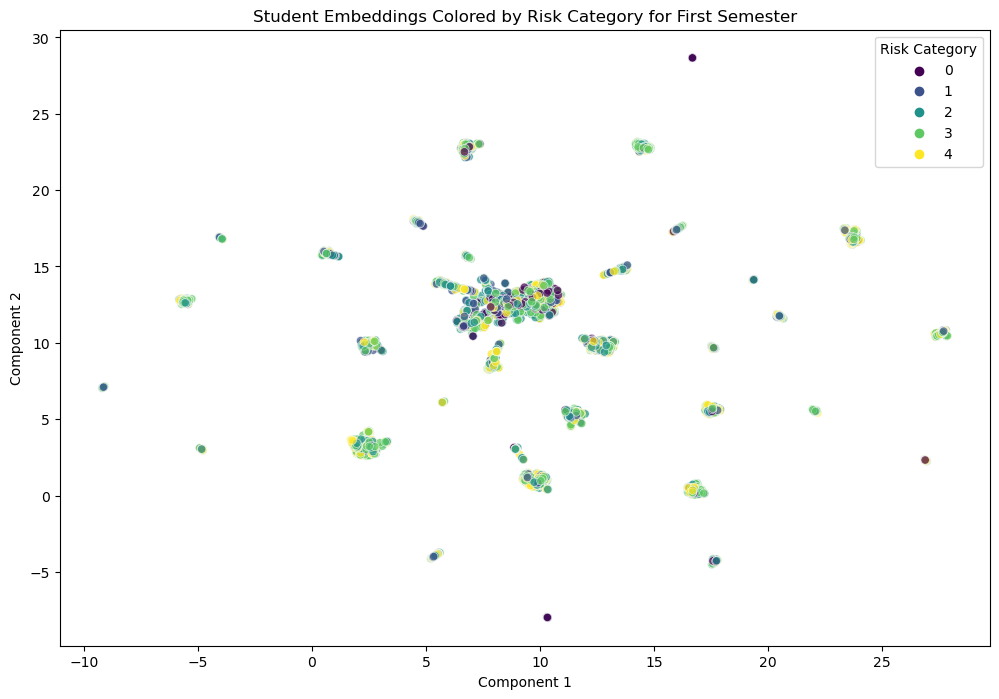

In [19]:
student_info_df = gpa_df[['student.id', 'student.term_gpa_program']]
student_info_df = student_info_df.drop_duplicates(subset=['student.id'])
student_info_df['risk_category'] = student_info_df['student.term_gpa_program'].apply(
    lambda x: 0 if x < 75 else
              1 if x < 85 else
              2 if x < 90 else
              3 if x < 95 else 4
)

risk_category_dict = dict(zip(student_info_df['student.id'].astype(str), student_info_df['risk_category']))

# Get risk categories for the embeddings
risk_categories = [risk_category_dict.get(student_id, -1) for student_id in student_ids]

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=embedding_2d[:, 0],
    y=embedding_2d[:, 1],
    hue=risk_categories,
    palette='viridis',
    alpha=0.7
)

plt.title(f'Student Embeddings Colored by Risk Category for {semester}')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(title='Risk Category')
plt.show()


In [ ]:
# 3D umap
reducer = umap.UMAP(n_components=3, random_state=42)
embedding_3d = reducer.fit_transform(embedding_array)

from mpl_toolkits.mplot3d import Axes3D

c:\Users\tafoy\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


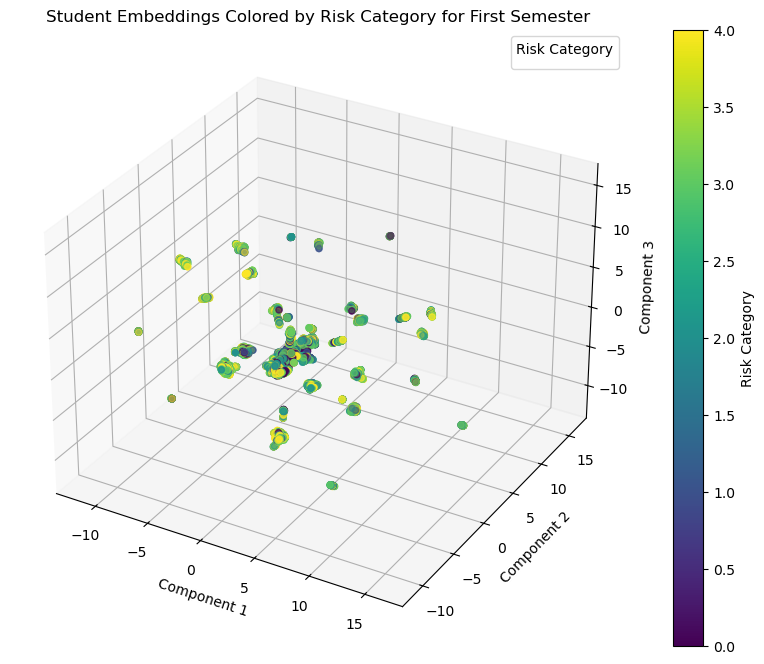

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

student_info_df = gpa_df[['student.id', 'student.term_gpa_program']]
student_info_df = student_info_df.drop_duplicates(subset=['student.id'])
student_info_df['risk_category'] = student_info_df['student.term_gpa_program'].apply(
    lambda x: 0 if x < 75 else
              1 if x < 85 else
              2 if x < 90 else
              3 if x < 95 else 4
)

risk_category_dict = dict(zip(student_info_df['student.id'].astype(str), student_info_df['risk_category']))

risk_categories = [risk_category_dict.get(student_id, -1) for student_id in student_ids]

ax.scatter(
    embedding_3d[:, 0],
    embedding_3d[:, 1],
    embedding_3d[:, 2],
    c=risk_categories,
    cmap='viridis',
    alpha=0.7
)

#colorbar
cbar = plt.colorbar(ax.scatter(embedding_3d[:, 0], embedding_3d[:, 1], embedding_3d[:, 2], c=risk_categories, cmap='viridis'))
cbar.set_label('Risk Category')

ax.set_title(f'Student Embeddings Colored by Risk Category for {semester}')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
ax.legend(title='Risk Category')
plt.show()


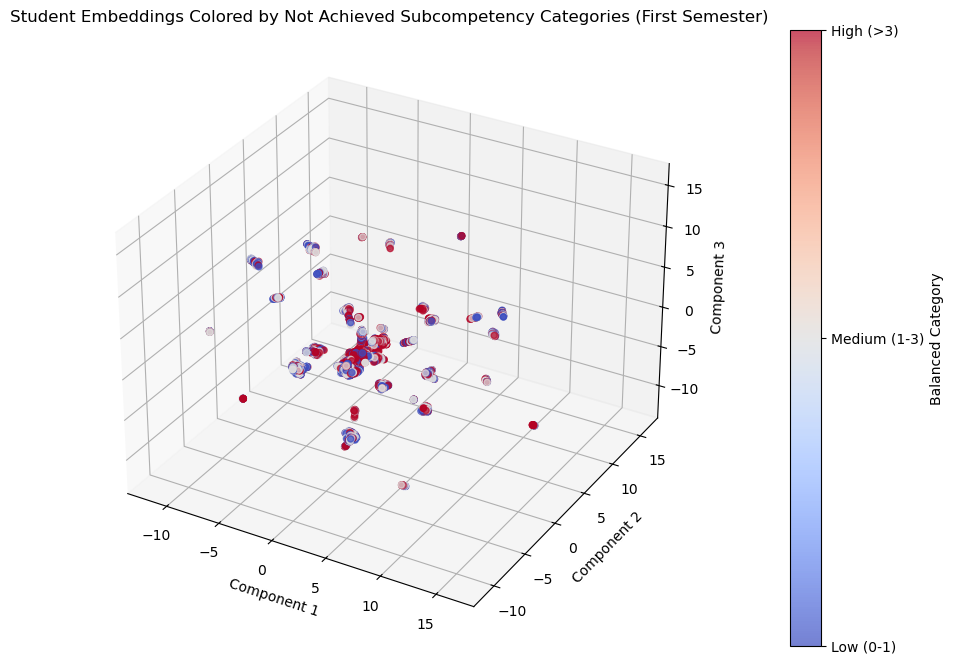

In [25]:
# 3D umap with not achieved subcompetencies

not_achieved_column = f'not_achieved_{semester}'
if not_achieved_column not in student_categories_df.columns:
    raise ValueError(f"The column '{not_achieved_column}' does not exist in the data.")

bins = [0, 1, 3, np.inf]
labels = ['Low (0-1)', 'Medium (1-3)', 'High (>3)']
student_categories_df['balanced_category'] = pd.cut(
    student_categories_df[not_achieved_column],
    bins=bins,
    labels=labels,
    right=False
)

balanced_category_dict = dict(zip(student_categories_df['student.id'].astype(str), student_categories_df['balanced_category']))
not_achieved_categories = [balanced_category_dict.get(student_id, 'Unknown') for student_id in student_ids]

# Map category labels to integers for color mapping
category_to_int = {label: idx for idx, label in enumerate(labels)}
colors = [category_to_int[cat] if cat in category_to_int else -1 for cat in not_achieved_categories]

# 3D Scatter Plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    embedding_3d[:, 0],
    embedding_3d[:, 1],
    embedding_3d[:, 2],
    c=colors,
    cmap='coolwarm',
    alpha=0.7
)

# Add a color bar for the categories
colorbar = fig.colorbar(scatter, ax=ax, pad=0.1)
colorbar.set_ticks([0, 1, 2])
colorbar.set_ticklabels(labels)
colorbar.set_label('Balanced Category')

# Set plot labels and title
ax.set_title(f'Student Embeddings Colored by Not Achieved Subcompetency Categories ({semester})')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')

plt.show()

In [43]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
embedding_2d = pca.fit_transform(embedding_array)

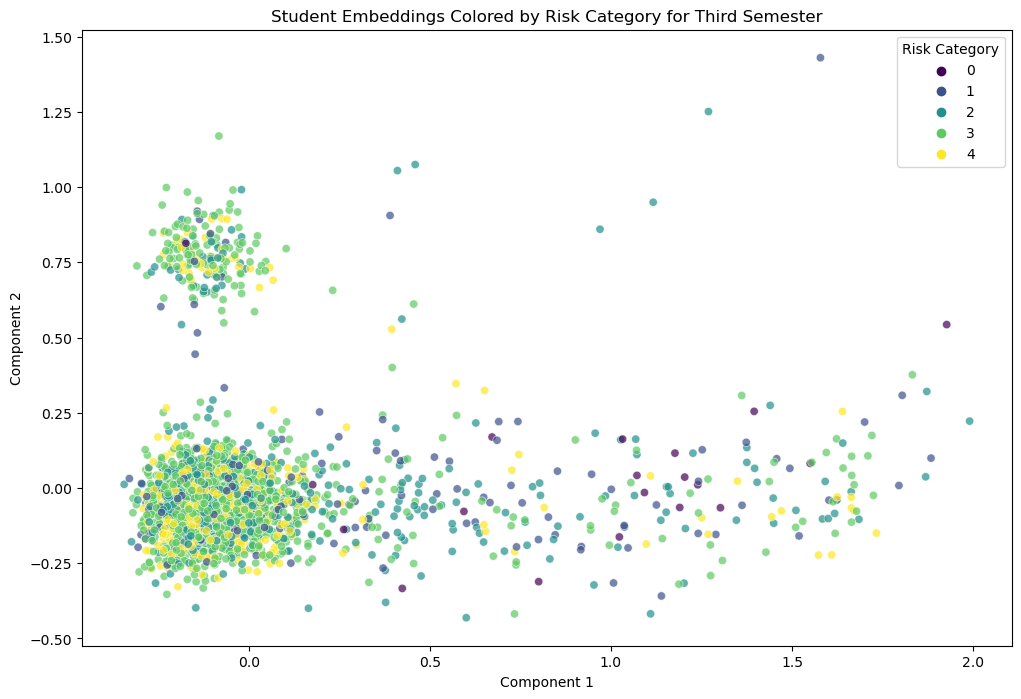

In [44]:
student_info_df = gpa_df[['student.id', 'student.term_gpa_program']]
student_info_df = student_info_df.drop_duplicates(subset=['student.id'])
student_info_df['risk_category'] = student_info_df['student.term_gpa_program'].apply(
    lambda x: 0 if x < 75 else
              1 if x < 85 else
              2 if x < 90 else
              3 if x < 95 else 4
)

risk_category_dict = dict(zip(student_info_df['student.id'].astype(str), student_info_df['risk_category']))

# Get risk categories for the embeddings
risk_categories = [risk_category_dict.get(student_id, -1) for student_id in student_ids]

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=embedding_2d[:, 0],
    y=embedding_2d[:, 1],
    hue=risk_categories,
    palette='viridis',
    alpha=0.7
)

plt.title(f'Student Embeddings Colored by Risk Category for {semester}')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(title='Risk Category')
plt.show()

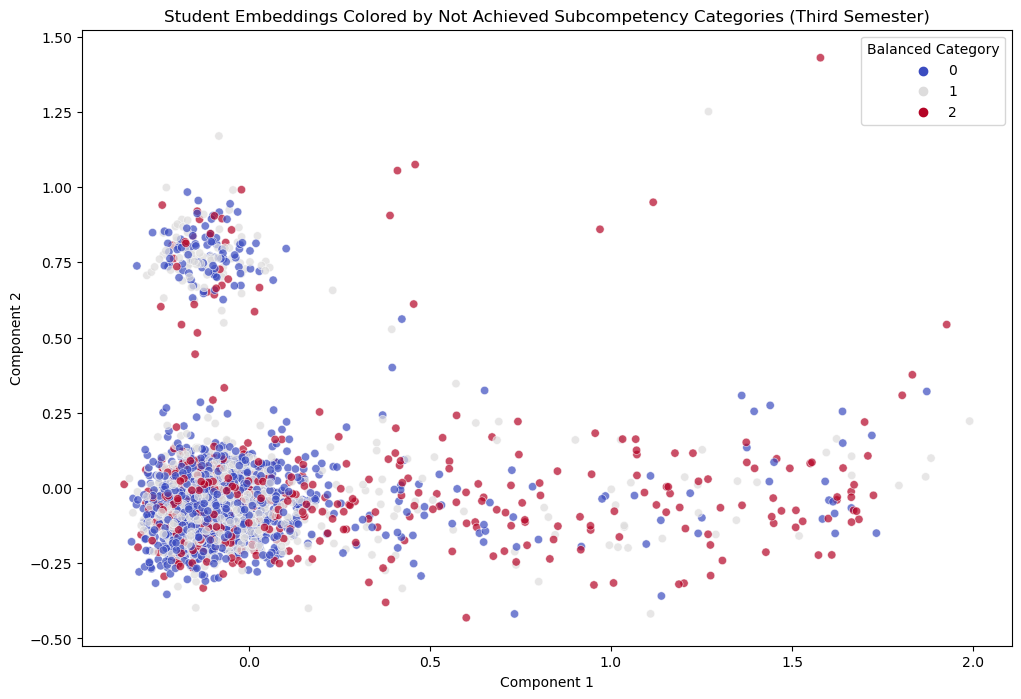

In [45]:
# 2d pca for not achieved subcompetencies

not_achieved_column = f'not_achieved_{semester}'
if not_achieved_column not in student_categories_df.columns:
    raise ValueError(f"The column '{not_achieved_column}' does not exist in the data.")

bins = [0, 1, 3, np.inf]
labels = ['Low (0-1)', 'Medium (1-3)', 'High (>3)']

student_categories_df['balanced_category'] = pd.cut(
    student_categories_df[not_achieved_column],
    bins=bins,
    labels=labels,
    right=False
)

balanced_category_dict = dict(zip(student_categories_df['student.id'].astype(str), student_categories_df['balanced_category']))
not_achieved_categories = [balanced_category_dict.get(student_id, 'Unknown') for student_id in student_ids]

# Map category labels to integers for color mapping
category_to_int = {label: idx for idx, label in enumerate(labels)}
colors = [category_to_int[cat] if cat in category_to_int else -1 for cat in not_achieved_categories]

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=embedding_2d[:, 0],
    y=embedding_2d[:, 1],
    hue=colors,
    palette='coolwarm',
    alpha=0.7
)

plt.title(f'Student Embeddings Colored by Not Achieved Subcompetency Categories ({semester})')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(title='Balanced Category')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


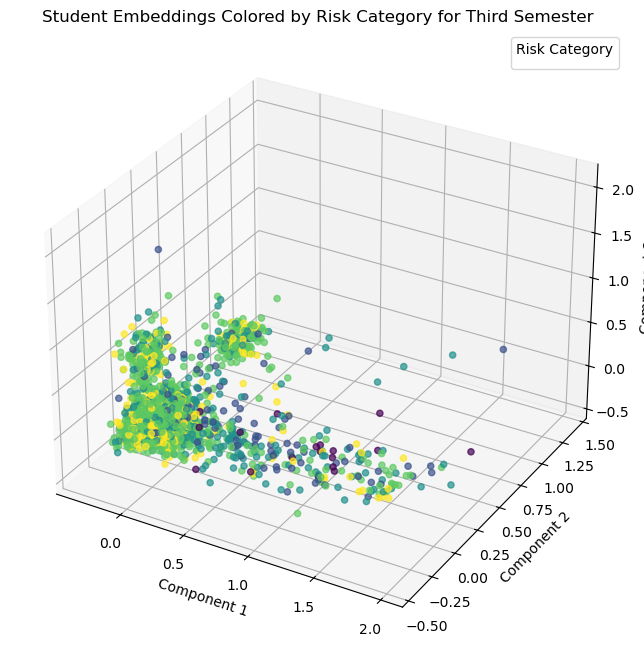

In [40]:
# 3d PCA
pca = PCA(n_components=3)
embedding_3d = pca.fit_transform(embedding_array)

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

student_info_df = gpa_df[['student.id', 'student.term_gpa_program']]
student_info_df = student_info_df.drop_duplicates(subset=['student.id'])
student_info_df['risk_category'] = student_info_df['student.term_gpa_program'].apply(
    lambda x: 0 if x < 75 else
              1 if x < 85 else
              2 if x < 90 else
              3 if x < 95 else 4
)

risk_category_dict = dict(zip(student_info_df['student.id'].astype(str), student_info_df['risk_category']))

risk_categories = [risk_category_dict.get(student_id, -1) for student_id in student_ids]

ax.scatter(
    embedding_3d[:, 0],
    embedding_3d[:, 1],
    embedding_3d[:, 2],
    c=risk_categories,
    cmap='viridis',
    alpha=0.7,
)
    

ax.set_title(f'Student Embeddings Colored by Risk Category for {semester}')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
ax.legend(title='Risk Category')
plt.show()

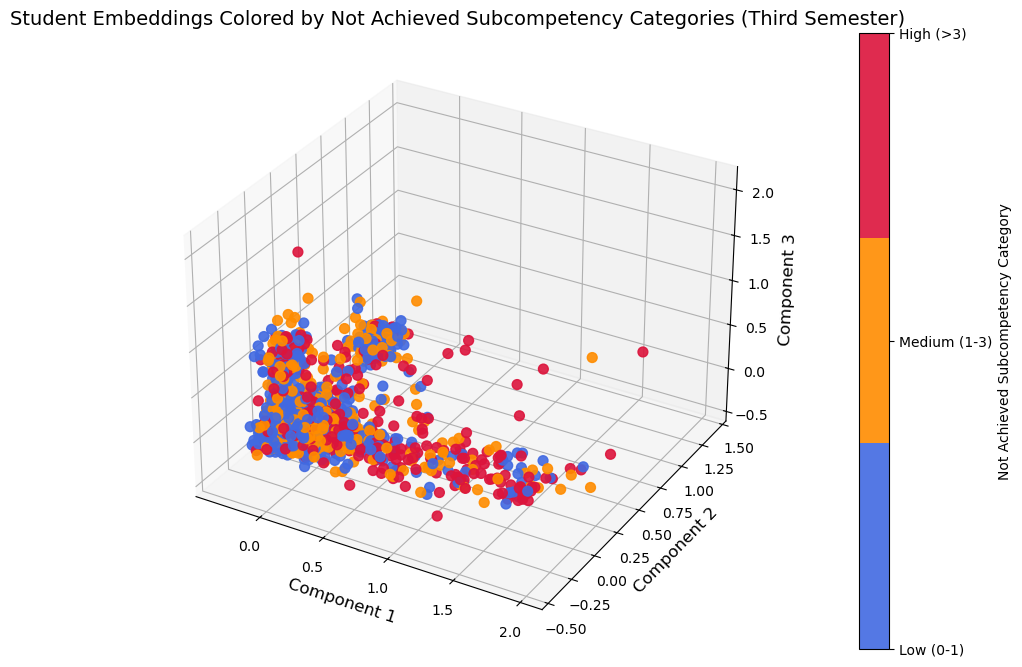

In [41]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.colors import ListedColormap

# Ensure "not achieved" column exists
not_achieved_column = f'not_achieved_{semester}'
if not_achieved_column not in student_categories_df.columns:
    raise ValueError(f"The column '{not_achieved_column}' does not exist in the data.")

# Discretize "not achieved" subcompetencies
bins = [0, 1, 3, np.inf]
labels = ['Low (0-1)', 'Medium (1-3)', 'High (>3)']
student_categories_df['balanced_category'] = pd.cut(
    student_categories_df[not_achieved_column],
    bins=bins,
    labels=labels,
    right=False
)

# Map student IDs to balanced categories
balanced_category_dict = dict(zip(student_categories_df['student.id'].astype(str), student_categories_df['balanced_category']))

# Map the balanced categories to embeddings
not_achieved_categories = [balanced_category_dict.get(student_id, 'Unknown') for student_id in student_ids]

# Handle missing categories and map them to integers for color mapping
category_to_int = {label: idx for idx, label in enumerate(labels)}
colors = [
    category_to_int[cat] if cat in category_to_int else -1  # Assign -1 for "Unknown" (if any)
    for cat in not_achieved_categories
]

# Remove unknown categories (if any)
valid_points = np.array(colors) != -1
embedding_3d_valid = embedding_3d[valid_points]
colors_valid = np.array(colors)[valid_points]

# Create a new vibrant colormap for the categories
vibrant_cmap = ListedColormap(['royalblue', 'darkorange', 'crimson'])

# Plot the 3D scatter with improved aesthetics
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    embedding_3d_valid[:, 0],
    embedding_3d_valid[:, 1],
    embedding_3d_valid[:, 2],
    c=colors_valid,
    cmap=vibrant_cmap,
    alpha=0.9,  # Reduce transparency for better visibility
    s=50        # Increase marker size
)

# Add a discrete color bar
colorbar = fig.colorbar(scatter, ax=ax, pad=0.1)
colorbar.set_ticks([0, 1, 2])
colorbar.set_ticklabels(labels)
colorbar.set_label('Not Achieved Subcompetency Category')

# Set plot labels and title
ax.set_title(f'Student Embeddings Colored by Not Achieved Subcompetency Categories ({semester})', fontsize=14)
ax.set_xlabel('Component 1', fontsize=12)
ax.set_ylabel('Component 2', fontsize=12)
ax.set_zlabel('Component 3', fontsize=12)

# Adjust gridlines for clarity
ax.grid(alpha=0.3)

plt.show()


In [ ]:
# GPA Average per student per semester
gpa_df['student.id'] = gpa_df['student.id'].astype(str)
gpa_df['student.semester_desc'] = gpa_df['student.semester_desc'].astype(str)

student_semester_gpa = gpa_df.groupby(['student.id', 'student.semester_desc'])['student.term_gpa_program'].mean().reset_index()
student_semester_gpa = student_semester_gpa.pivot(index='student.id', columns='student.semester_desc', values='student.term_gpa_program').reset_index()
student_semester_gpa = student_semester_gpa.fillna(0)

In [6]:
import pandas as pd
import numpy as np

# Load the original file with raw "not achieved" counts
student_df = pd.read_csv('student_subcompetence_analysis_with_nan.csv')

# Check the initial structure of the DataFrame
print("Initial DataFrame columns:")
print(student_df.columns)

# Define bins and labels for categorization
bins = [0, 1, 3, np.inf]  # Define bins for "not achieved" counts
labels = ['Low (0-1)', 'Medium (1-3)', 'High (>3)']  # Labels for categories

# Semester order to ensure alignment with the dataloader
semester_order = {
    'No information': 0,
    'First Semester': 1,
    'Second Semester': 2,
    'Third Semester': 3,
    'Fourth Semester': 4,
    'Fifth Semester': 5,
    'Sixth Semester': 6,
    'Seventh Semester': 7,
    'Eighth Semester': 8
}

# Create a new DataFrame to store only "not achieved" categories in the correct semester order
columns_to_keep = ['student.id'] + [f'not_achieved_{semester}' for semester in semester_order.keys()]
filtered_df = student_df[columns_to_keep]

# Rename "not achieved" columns to just the semester name
renamed_columns = {'not_achieved_' + semester: semester for semester in semester_order.keys()}
filtered_df = filtered_df.rename(columns=renamed_columns)

# Iterate over each renamed column and convert counts to categories
for semester in semester_order.keys():
    if semester in filtered_df.columns:
        filtered_df[semester] = pd.cut(filtered_df[semester], bins=bins, labels=labels, right=False)

# Save the updated DataFrame for later use
filtered_df.to_csv('student_subcompetence_analysis_by_semester.csv', index=False)
print("Updated DataFrame with categorized semesters saved.")

# Check the structure of the saved DataFrame
print("Filtered DataFrame columns:")
print(filtered_df.columns)


Initial DataFrame columns:
Index(['student.id', 'achieved_First Semester', 'not_achieved_First Semester',
       'achieved_Second Semester', 'not_achieved_Second Semester',
       'achieved_Third Semester', 'not_achieved_Third Semester',
       'achieved_Fourth Semester', 'not_achieved_Fourth Semester',
       'achieved_Fifth Semester', 'not_achieved_Fifth Semester',
       'achieved_Sixth Semester', 'not_achieved_Sixth Semester',
       'achieved_Seventh Semester', 'not_achieved_Seventh Semester',
       'achieved_Eighth Semester', 'not_achieved_Eighth Semester',
       'achieved_No information', 'not_achieved_No information'],
      dtype='object')
Updated DataFrame with categorized semesters saved.
Filtered DataFrame columns:
Index(['student.id', 'No information', 'First Semester', 'Second Semester',
       'Third Semester', 'Fourth Semester', 'Fifth Semester', 'Sixth Semester',
       'Seventh Semester', 'Eighth Semester'],
      dtype='object')


In [1]:
import pickle
embedding_path = './KG_gc/student_embeddings.pkl'
embeddings = pickle.load(open(embedding_path, 'rb'))

In [2]:
import pandas as pd
import numpy as np

In [3]:
# Use embeddings to predict student GPA in the next semester
from data.dataloader import get_dataloaders
student_subcompetence_df = pd.read_csv('student_subcompetence_analysis_by_semester.csv')
train_loader, test_loader, full_dataset = get_dataloaders(student_subcompetence_df, embeddings, batch_size=32)

Number of samples in X: 6103
Number of samples in y: 6103


In [4]:
print(len(full_dataset))
print(len(train_loader))
print(len(test_loader))
print(full_dataset[0])

6103
153
39
(tensor([ 0.2741,  0.2075,  0.0913,  0.0635,  0.0461, -0.0581, -0.0050,  0.0671,
        -0.1623,  0.1415,  0.1988, -0.0052, -0.3385,  0.0146, -0.2134,  0.0102,
        -0.2536, -0.0506, -0.0521, -0.0494, -0.0039,  0.1624,  0.1727, -0.0680,
        -0.2181, -0.1982, -0.0133,  0.1433, -0.0393, -0.2444,  0.1150, -0.1653,
         0.0891, -0.0231, -0.0760,  0.2167, -0.1237, -0.1334, -0.2240,  0.1808,
        -0.1156,  0.1549,  0.0263, -0.1805,  0.1264, -0.0146, -0.2528,  0.2936,
         0.1919,  0.1159,  0.1564,  0.3060, -0.0702, -0.1008,  0.0351,  0.2474,
         0.1392,  0.1644,  0.0823, -0.1841, -0.0734,  0.0995,  0.0400, -0.0065,
         0.2156, -0.2174,  0.1395,  0.0764, -0.0548, -0.1318,  0.1060, -0.1335,
        -0.2180, -0.2004,  0.0051, -0.1266, -0.0822,  0.1524, -0.1652,  0.1606,
         0.2395, -0.0184,  0.1435,  0.0918, -0.0356,  0.1343,  0.0590, -0.2088,
         0.0878,  0.2231, -0.0910, -0.0663,  0.2124,  0.0676,  0.0898,  0.0906,
         0.1465,  0.0370,  

In [5]:
from models.model import RiskClassifier, CategoryClassifier
from models.losses import FocalLoss
from torch import nn, optim
import torch
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
X_train, y_train = next(iter(train_loader))
input_dim = X_train.shape[1]
num_classes = 3  # Low, Medium, High
model = CategoryClassifier(input_dim, num_classes)

# Define Cross-Entropy Loss (no weights since classes are balanced)
criterion = nn.CrossEntropyLoss()

# Define optimizer and scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)

# Early stopping setup
best_val_loss = float('inf')
epochs_without_improvement = 0
patience = 100
epochs = 1000

# Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_X.size(0)
    
    train_loss /= len(train_loader.dataset)
    
    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item() * batch_X.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)
    
    val_loss /= len(test_loader.dataset)
    val_accuracy = 100 * correct / total
    
    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Val Accuracy = {val_accuracy:.2f}%")
    
    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_without_improvement += 1
    
    if epochs_without_improvement >= patience:
        print("Early stopping.")
        break

Epoch 1: Train Loss = 1.0756, Val Loss = 1.0693, Val Accuracy = 43.33%
Epoch 2: Train Loss = 1.0687, Val Loss = 1.0680, Val Accuracy = 43.33%
Epoch 3: Train Loss = 1.0623, Val Loss = 1.0640, Val Accuracy = 43.08%
Epoch 4: Train Loss = 1.0519, Val Loss = 1.0628, Val Accuracy = 42.67%
Epoch 5: Train Loss = 1.0429, Val Loss = 1.0650, Val Accuracy = 43.00%
Epoch 6: Train Loss = 1.0359, Val Loss = 1.0696, Val Accuracy = 41.69%
Epoch 7: Train Loss = 1.0300, Val Loss = 1.0669, Val Accuracy = 42.51%
Epoch 8: Train Loss = 1.0214, Val Loss = 1.0673, Val Accuracy = 42.75%
Epoch 9: Train Loss = 1.0146, Val Loss = 1.0678, Val Accuracy = 41.36%
Epoch 10: Train Loss = 1.0037, Val Loss = 1.0705, Val Accuracy = 42.67%
Epoch 11: Train Loss = 0.9939, Val Loss = 1.0812, Val Accuracy = 42.67%
Epoch 12: Train Loss = 0.9837, Val Loss = 1.0814, Val Accuracy = 42.51%
Epoch 13: Train Loss = 0.9711, Val Loss = 1.0841, Val Accuracy = 41.36%
Epoch 14: Train Loss = 0.9597, Val Loss = 1.0956, Val Accuracy = 40.05%
E

In [ ]:
from sklearn.metrics import classification_report

# Load best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Generate predictions
all_preds = []
all_targets = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(batch_y.cpu().numpy())

print("Classification Report:")
print(classification_report(all_targets, all_preds, target_names=['Low (0-1)', 'Medium (1-3)', 'High (>3)'], digits=4))
